# Autoencoder

In this TP we will work on autoencoder on the MNIST dataset

In [34]:
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib import cm
import matplotlib
from sklearn.manifold import MDS
def graph_colors(nx_graph):
    #cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["blue","red"])
    #cm1 = mcol.Colormap('viridis')

    cnorm = mcol.Normalize(vmin=0,vmax=10)
    cpick = cm.ScalarMappable(norm=cnorm,cmap='Set1')
    cpick.set_array([])
    val_map = {}
    for k,v in nx.get_node_attributes(nx_graph,'attr').items():
        #print(v)
        val_map[k]=cpick.to_rgba(v)
    #print(val_map)
    colors=[]
    for node in nx_graph.nodes():
        #print(node,val_map.get(str(node), 'black'))
        colors.append(val_map[node])
    return colors

##### 1 Write a function that builds a simple autoencoder 

The autoencoder must have a simple Dense layer with relu activation. The number of node of the dense layer is a parameter of the function

The function must return the entire autoencoder model as well as the encoder and the decoder

In [8]:
def build_simple_autoencoder(encoding_dim=32):
    input_img = Input(shape=(784,))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')   
    return autoencoder,encoder,decoder

Load the mnist dataset

In [9]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


##### 2. Buil the autoencoder with a embedding size of 32 and print the number of parameters of the model. What do they relate to ?

In [11]:
autoencoder,encoder,decoder=build_simple_autoencoder(32)

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [16]:
2*784*32+784+32

50992

##### 3. Fit the autoencoder using 32 epochs with a batch size of 256

In [17]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.3607 - val_loss: 0.2721
Epoch 2/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.2667 - val_loss: 0.2584
Epoch 3/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.2481 - val_loss: 0.2351
Epoch 4/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.2258 - val_loss: 0.2151
Epoch 5/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.2097 - val_loss: 0.2020
Epoch 6/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.1986 - val_loss: 0.1926
Epoch 7/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.1900 - val_loss: 0.1848
Epoch 8/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1827 - val_loss: 0.1778
Epoch 9/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1760 - val_loss: 0.1716
Epoch

##### 4. Using the history module of the autoencoder write a function that plots the learning curves with respect to the epochs on the train and test set. What can you say about these learning curves ? Give also the last loss on the test set

In [18]:
def plot_learning_curves(autoencoder):
    history=autoencoder.history
    # summarize history for loss
    plt.figure(figsize=(7,7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

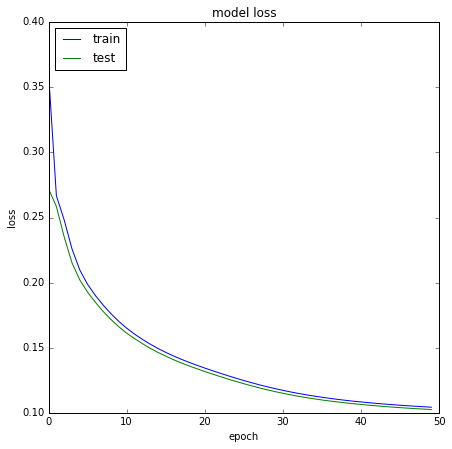

In [19]:
plot_learning_curves(autoencoder)

In [20]:
autoencoder.history.history['val_loss'][::-1][0]

0.10251018644571304

##### 5. Write a function that plots a fix number of example of the original images on the test as weel as their reconstruction

In [21]:
def plot_reconstructed_images(encoder,decoder,x_test):
   # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    print('Mean encoded image : %.2f' %encoded_imgs.mean())
    decoded_imgs = decoder.predict(encoded_imgs)
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Mean encoded image : 7.40


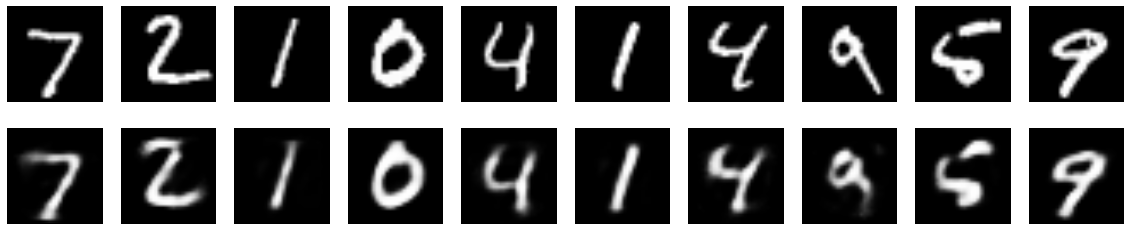

In [22]:
plot_reconstructed_images(encoder,decoder,x_test)

### Nearest neighbours graphs

The goal of this part is to visualize the neighbours graph in the embedding. It corresponds the the graph of the k-nearest neighbours using the euclidean distance of points the element in the embedding

In [23]:
from sklearn.neighbors import kneighbors_graph
import networkx as nx

In [26]:
def plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3): #to explain
    X=encoder.predict(x_test[1:ntest])
    y=y_test[1:ntest]
    A = kneighbors_graph(X, p, mode='connectivity', include_self=True)
    G=nx.from_numpy_array(A.toarray())
    nx.set_node_attributes(G,dict(zip(range(ntest),y)),'attr')
    fig, ax = plt.subplots(figsize=(10,10))
    pos=nx.layout.kamada_kawai_layout(G)
    nx.draw(G,pos=pos
            ,with_labels=True
            ,labels=nx.get_node_attributes(G,'attr')
            ,node_color=graph_colors(G))
    plt.tight_layout()
    plt.title('Nearest Neighbours Graph',fontsize=15)
    plt.show()

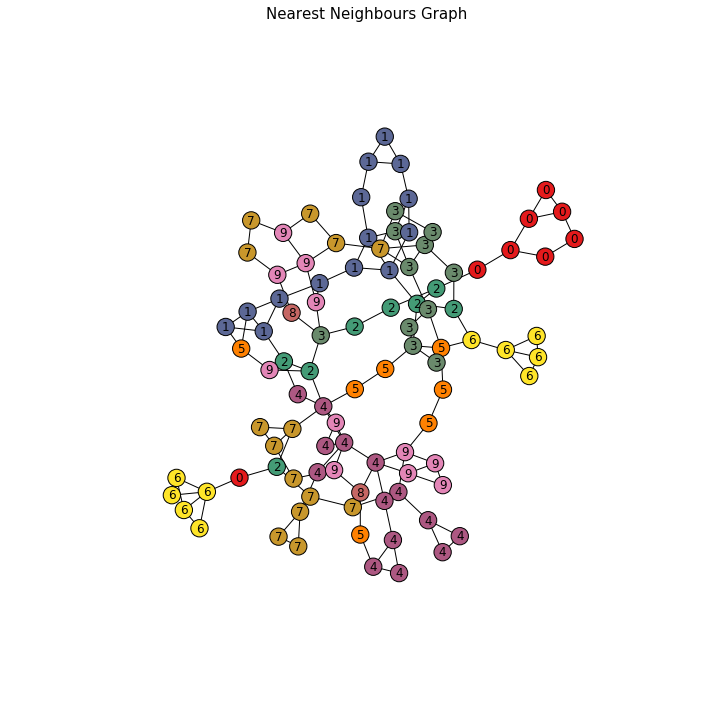

In [35]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

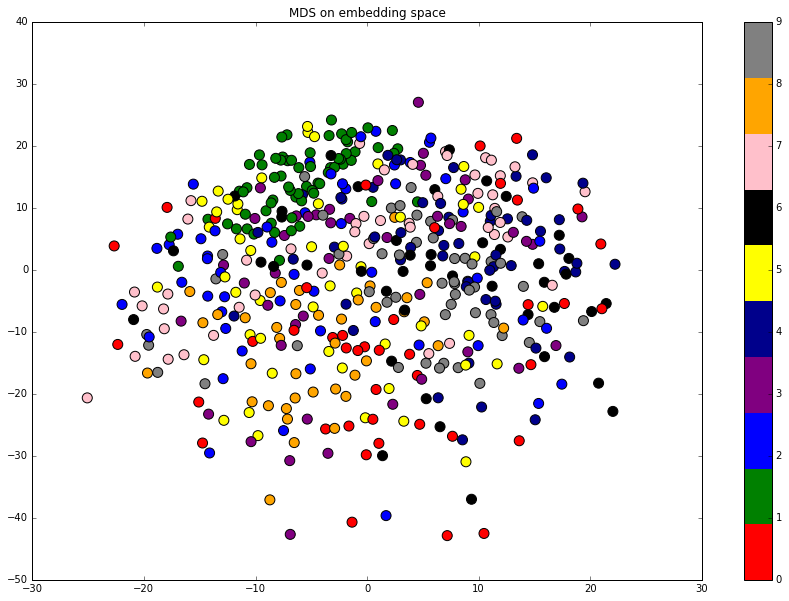

In [83]:
ntest=500
mds=MDS(n_components=2)
X=encoder.predict(x_test[1:ntest])
X_dim2=mds.fit_transform(X)
colors = ['red','green','blue','purple','darkblue','yellow','black','pink','orange','grey']
label=y_test[1:ntest]
plt.figure(figsize=(15,10))
plt.scatter(X_dim2[:,0]
            ,X_dim2[:,1]
            ,c=label,cmap=matplotlib.colors.ListedColormap(colors)
           ,s=100)
plt.colorbar()
plt.title('MDS on embedding space')
plt.show()

What can you say about this graph ?

### Reduce the dimension of the embedding

##### 6. Rerun the previous example using an embedding dimension of 16

In [60]:
autoencoder,encoder,decoder=build_simple_autoencoder(16)

In [61]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               13328     
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________


In [62]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.3736 - val_loss: 0.2731
Epoch 2/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.2680 - val_loss: 0.2602
Epoch 3/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2525 - val_loss: 0.2425
Epoch 4/50
60000/60000 [==============================] - 4s 62us/step - loss: 0.2348 - val_loss: 0.2246
Epoch 5/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2187 - val_loss: 0.2101
Epoch 6/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2060 - val_loss: 0.1994
Epoch 7/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.1971 - val_loss: 0.1924
Epoch 8/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1911 - val_loss: 0.1871
Epoch 9/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.1864 - val_loss: 0.1827
Epoch

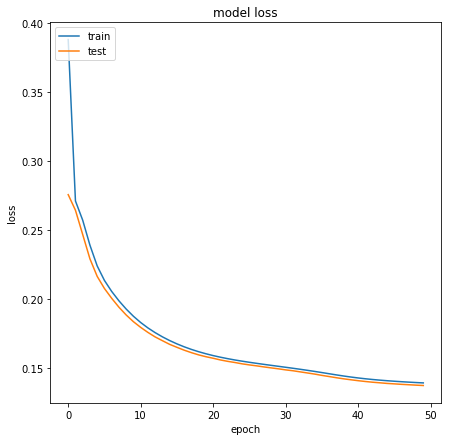

In [43]:
plot_learning_curves(autoencoder)

In [44]:
autoencoder.history.history['val_loss'][::-1][0]

0.1370394513130188

Mean encoded image : 9.14


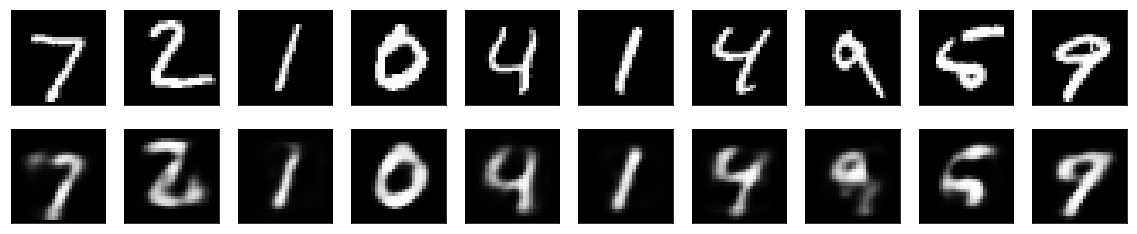

In [45]:
plot_reconstructed_images(encoder,decoder,x_test)

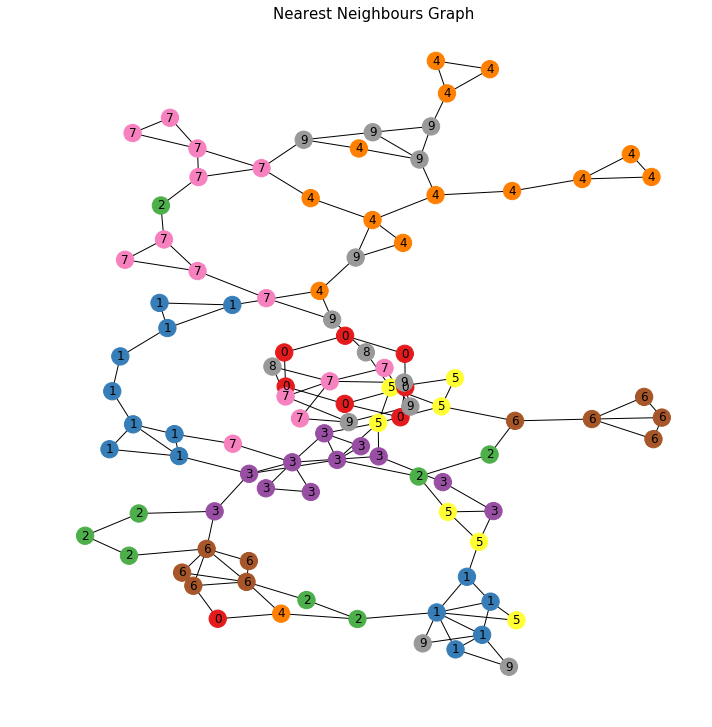

In [46]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

## Adding sparsity

##### 7.  In this part we will add sparisity over the weights on the embedding layer. Write a function that build such a autoencoder (using a l1 regularization with a configurable regularization parameter and using the same autoencoder architecture that before)

In [49]:
from keras import regularizers

In [50]:
def build_regularized_autoencoder(encoding_dim=32,regul=10e-5):
    
    # this is the size of our encoded representations
    encoding_dim = encoding_dim  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

    # this is our input placeholder
    input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(regul))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(784, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder,encoder,decoder

##### 8. Run the previous example with the same epochs, batch_size and comment.

In [51]:
autoencoder,encoder,decoder=build_regularized_autoencoder()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [52]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 0.6842 - val_loss: 0.6607
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 0.6440 - val_loss: 0.6272
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 0.6111 - val_loss: 0.5952
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 0.5802 - val_loss: 0.5655
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 0.5518 - val_loss: 0.5386
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 0.5263 - val_loss: 0.5146
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 0.5036 - val_loss: 0.4932
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 0.4835 - val_loss: 0.4744
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 0.4658 - val_loss: 0.4577
Epoch 10/50
60000/60000 [==============================] - 2s - loss: 0.4501 - val_loss: 0.4430

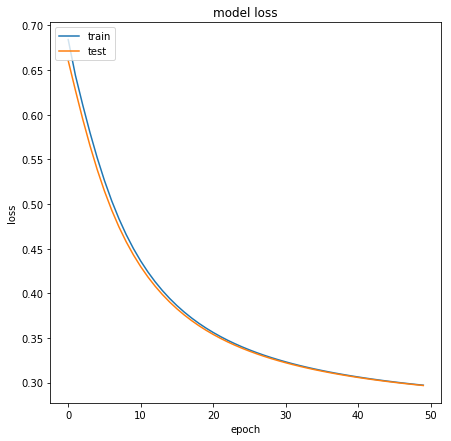

In [53]:
plot_learning_curves(autoencoder)

In [54]:
autoencoder.history.history['val_loss'][::-1][0]

0.2966866099834442

Mean encoded image : 0.00


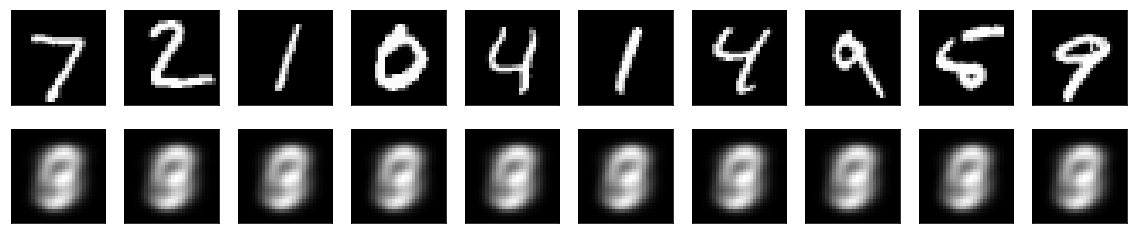

In [55]:
plot_reconstructed_images(encoder,decoder,x_test)

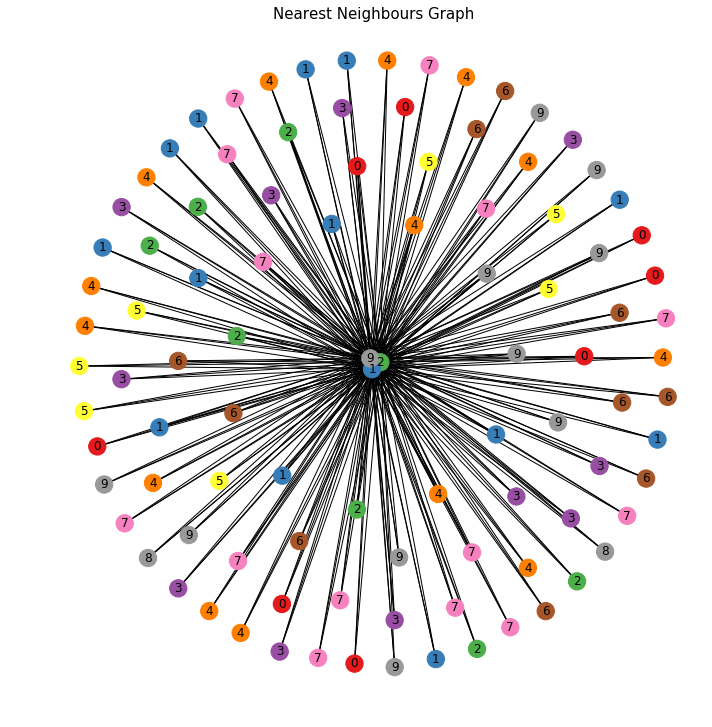

In [56]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

To much regularization... We decrease the regul parameter

In [57]:
autoencoder,encoder,decoder=build_regularized_autoencoder(regul=10e-7)

In [58]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 0.3925 - val_loss: 0.2945
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 0.2873 - val_loss: 0.2778
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 0.2681 - val_loss: 0.2560
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 0.2478 - val_loss: 0.2374
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 0.2318 - val_loss: 0.2235
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 0.2200 - val_loss: 0.2135
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 0.2112 - val_loss: 0.2059
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 0.2043 - val_loss: 0.1998
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 0.1988 - val_loss: 0.1948
Epoch 10/50
60000/60000 [==============================] - 2s - loss: 0.1941 - val_loss: 0.1905

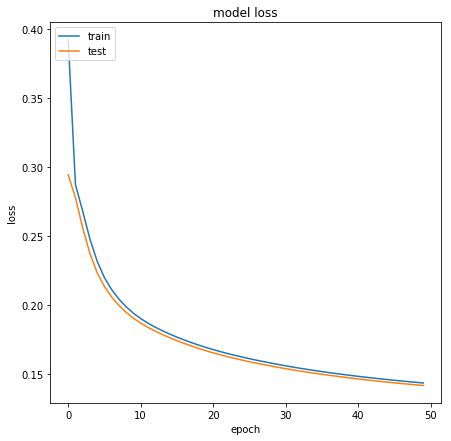

In [59]:
plot_learning_curves(autoencoder)

In [60]:
autoencoder.history.history['val_loss'][::-1][0]

0.1417577787399292

Mean encoded image : 1.88


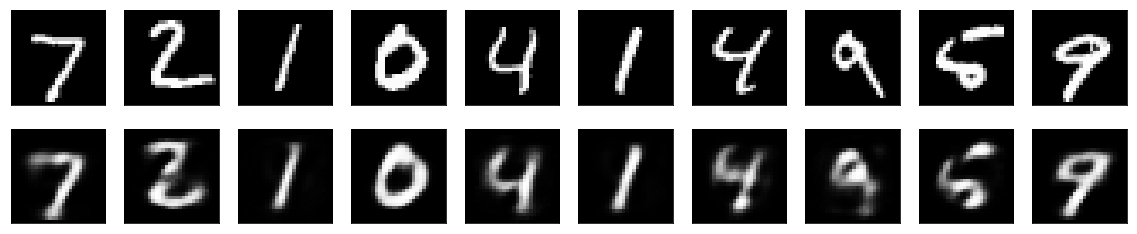

In [61]:
plot_reconstructed_images(encoder,decoder,x_test)

The mean of the encoded image is less than before -> due to the sparsity

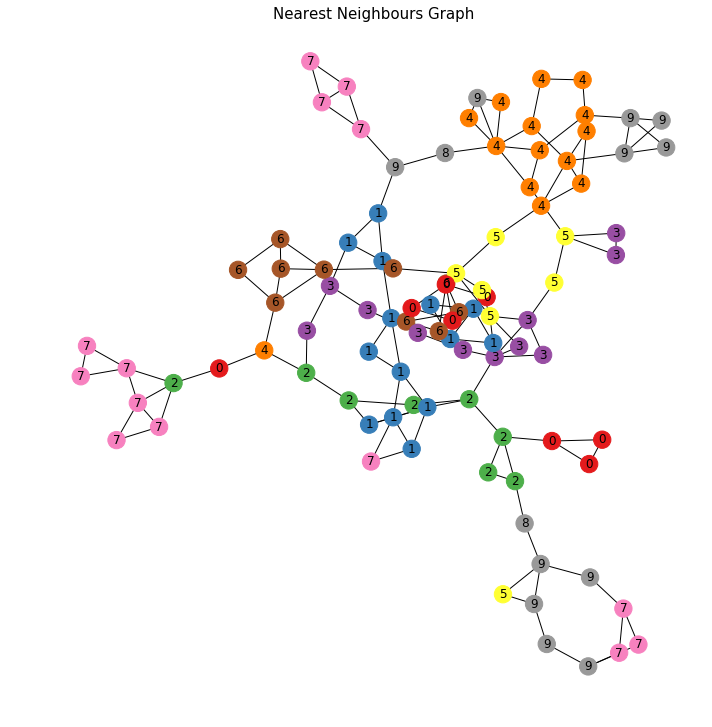

In [62]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

# Deep autoencoder

In [84]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [85]:
def build_deep_autoencoder(encoding_dim=32):
    

    input_img = Input(shape=(784,))
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu', name="embedding_layer")(encoded)

    encoder=Model(input_img, encoded)

    
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_img, decoded)
    

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder,encoder

In [86]:
autoencoder,encoder=build_deep_autoencoder()

In [87]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
embedding_layer (Dense)      (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 784)               101136    
Total para

In [88]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.3319 - val_loss: 0.2632
Epoch 2/50
60000/60000 [==============================] - 7s 114us/step - loss: 0.2579 - val_loss: 0.2527
Epoch 3/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.2449 - val_loss: 0.2381
Epoch 4/50
60000/60000 [==============================] - 7s 115us/step - loss: 0.2283 - val_loss: 0.2195
Epoch 5/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.2145 - val_loss: 0.2091
Epoch 6/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.2071 - val_loss: 0.2027
Epoch 7/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.1975 - val_loss: 0.1914
Epoch 8/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.1887 - val_loss: 0.1833
Epoch 9/50
60000/60000 [==============================] - 6s 94us/step - loss: 0.1812 - val_loss: 0.177

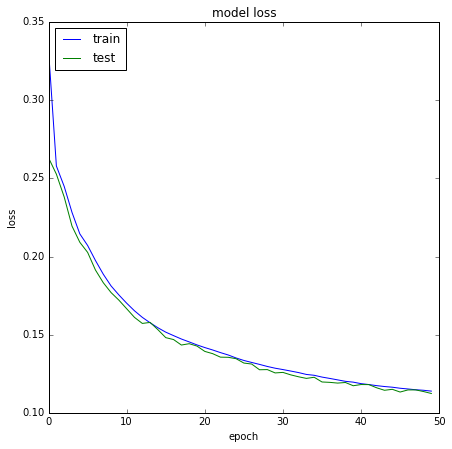

In [89]:
plot_learning_curves(autoencoder)

In [90]:
autoencoder.history.history['val_loss'][::-1][0]

0.11236508156061173

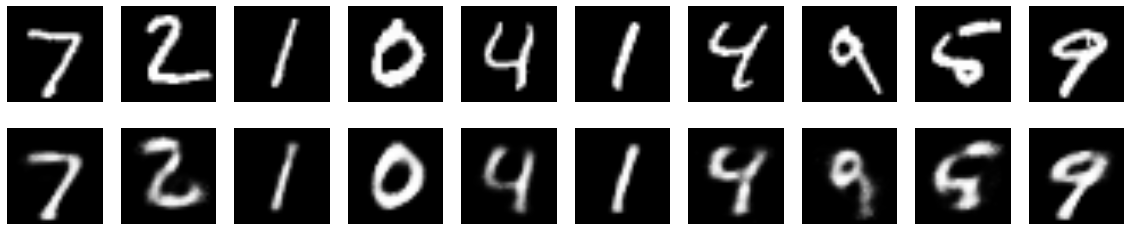

In [91]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

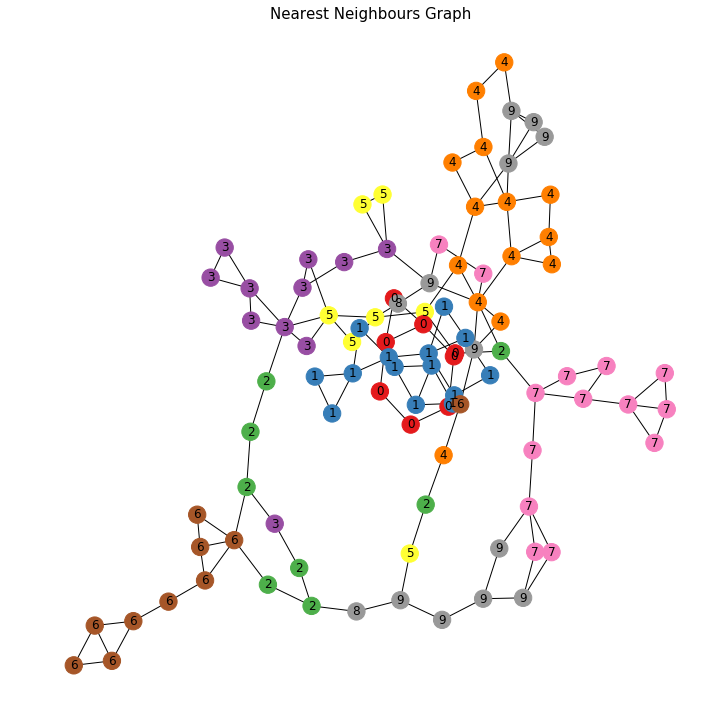

In [196]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

In [197]:
autoencoder,encoder=build_deep_autoencoder()

In [198]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s - loss: 0.3326 - val_loss: 0.2636
Epoch 2/100
60000/60000 [==============================] - 3s - loss: 0.2578 - val_loss: 0.2514
Epoch 3/100
60000/60000 [==============================] - 3s - loss: 0.2442 - val_loss: 0.2375
Epoch 4/100
60000/60000 [==============================] - 3s - loss: 0.2292 - val_loss: 0.2162
Epoch 5/100
60000/60000 [==============================] - 3s - loss: 0.2089 - val_loss: 0.2000
Epoch 6/100
60000/60000 [==============================] - 3s - loss: 0.1952 - val_loss: 0.1886
Epoch 7/100
60000/60000 [==============================] - 3s - loss: 0.1856 - val_loss: 0.1814
Epoch 8/100
60000/60000 [==============================] - 3s - loss: 0.1802 - val_loss: 0.1772
Epoch 9/100
60000/60000 [==============================] - 3s - loss: 0.1759 - val_loss: 0.1722
Epoch 10/100
60000/60000 [==============================] - 3s - loss: 0.1714 - val_lo

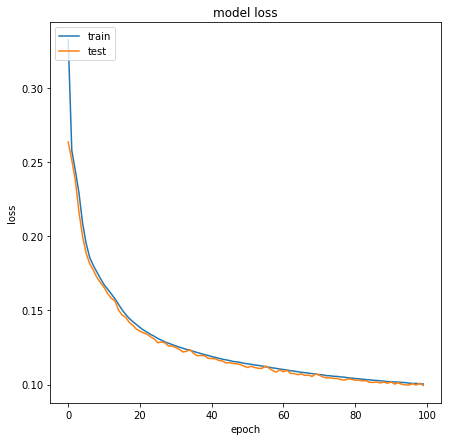

In [199]:
plot_learning_curves(autoencoder)

In [200]:
autoencoder.history.history['val_loss'][::-1][0]

0.09933427510261536

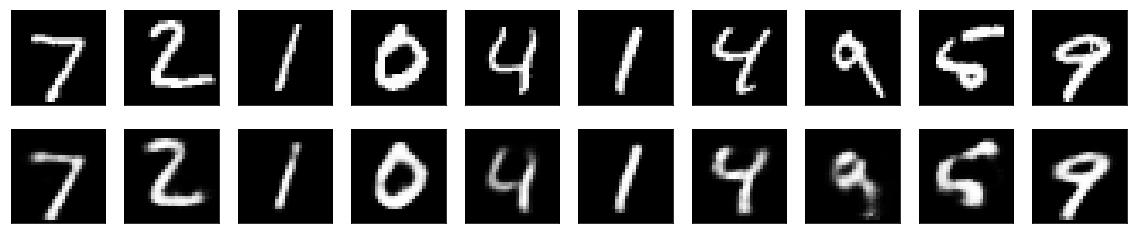

In [201]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutionnal autoencoder

In [92]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


In [93]:
def build_conv_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    encoder= Model(input_img, encoded)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    
    return autoencoder,encoder

In [94]:
autoencoder,encoder=build_conv_autoencoder()

In [95]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [96]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [97]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 170s 3ms/step - loss: 0.1332 - val_loss: 0.0899
Epoch 2/10
60000/60000 [==============================] - 176s 3ms/step - loss: 0.0862 - val_loss: 0.0817
Epoch 3/10
26880/60000 [============>.................] - ETA: 1:31 - loss: 0.0813

KeyboardInterrupt: 

In [98]:
autoencoder.history.history['val_loss'][::-1][0]

0.081677189183235174

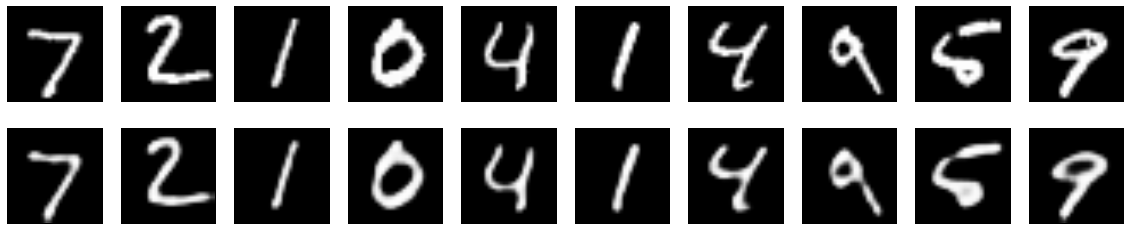

In [99]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [116]:
X=encoder.predict(x_test[1:100])

In [117]:
X.shape

(99, 7, 7, 32)

In [118]:
X=X.reshape((99,7*7*32))

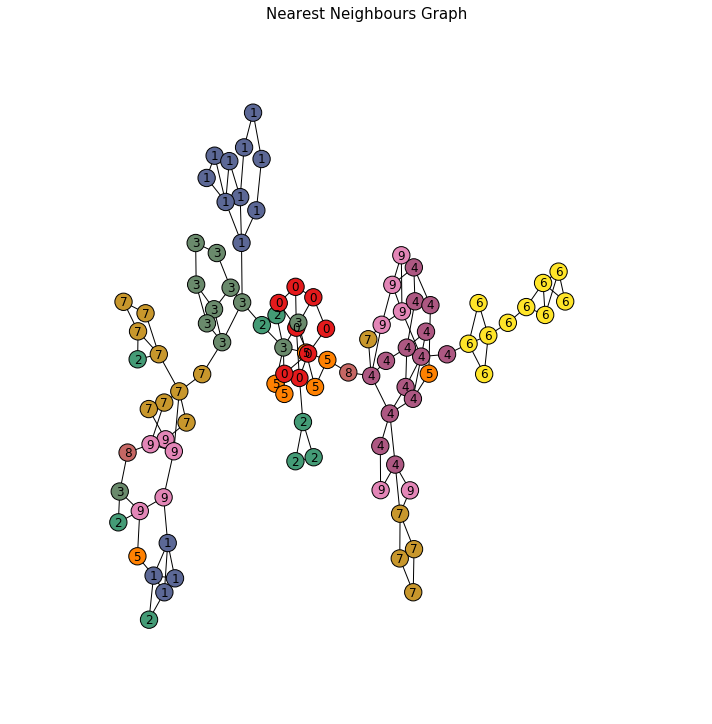

In [121]:
y=y_test[1:100]
A = kneighbors_graph(X, 3, mode='connectivity', include_self=True)
G=nx.from_numpy_array(A.toarray())
nx.set_node_attributes(G,dict(zip(range(100),y)),'attr')
fig, ax = plt.subplots(figsize=(10,10))
pos=nx.layout.kamada_kawai_layout(G)
nx.draw(G,pos=pos
        ,with_labels=True
        ,labels=nx.get_node_attributes(G,'attr')
        ,node_color=graph_colors(G))
plt.tight_layout()
plt.title('Nearest Neighbours Graph',fontsize=15)
plt.show()

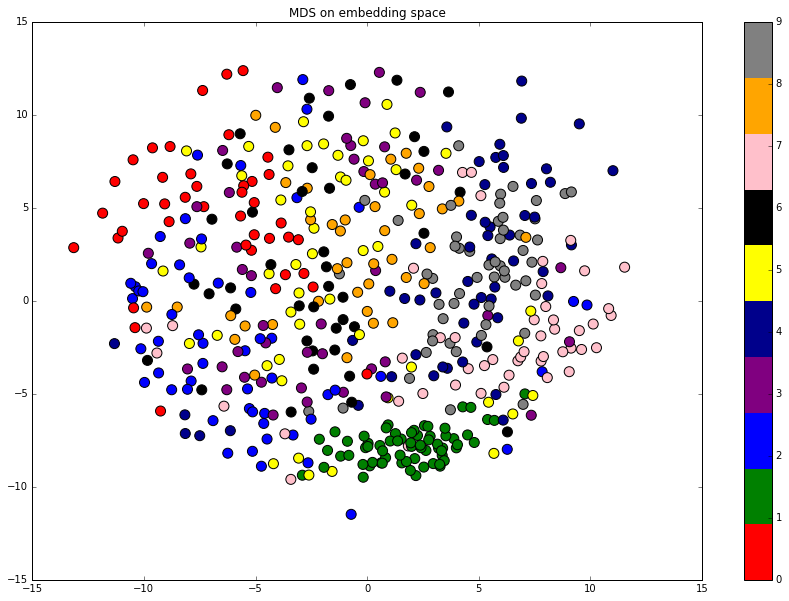

In [122]:
ntest=500
mds=MDS(n_components=2)
X=encoder.predict(x_test[1:ntest])
X_dim2=mds.fit_transform(X.reshape((ntest-1,7*7*32)))
colors = ['red','green','blue','purple','darkblue','yellow','black','pink','orange','grey']
label=y_test[1:ntest]
plt.figure(figsize=(15,10))
plt.scatter(X_dim2[:,0]
            ,X_dim2[:,1]
            ,c=label,cmap=matplotlib.colors.ListedColormap(colors)
           ,s=100)
plt.colorbar()
plt.title('MDS on embedding space')
plt.show()

# Application to denoising

In [180]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [185]:
autoencoder,encoder=build_conv_autoencoder()

In [186]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test)
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 92s - loss: 0.1964 - val_loss: 0.1307
Epoch 2/20
60000/60000 [==============================] - 103s - loss: 0.1244 - val_loss: 0.1152
Epoch 3/20
60000/60000 [==============================] - 88s - loss: 0.1151 - val_loss: 0.1098
Epoch 4/20
60000/60000 [==============================] - 88s - loss: 0.1106 - val_loss: 0.1080
Epoch 5/20
60000/60000 [==============================] - 94s - loss: 0.1080 - val_loss: 0.1058
Epoch 6/20
60000/60000 [==============================] - 90s - loss: 0.1061 - val_loss: 0.1062
Epoch 7/20
60000/60000 [==============================] - 89s - loss: 0.1047 - val_loss: 0.1037
Epoch 8/20
60000/60000 [==============================] - 89s - loss: 0.1037 - val_loss: 0.1019
Epoch 9/20
60000/60000 [==============================] - 92s - loss: 0.1028 - val_loss: 0.1008
Epoch 10/20
60000/60000 [==============================] - 92s - loss: 0.1021 - val_l

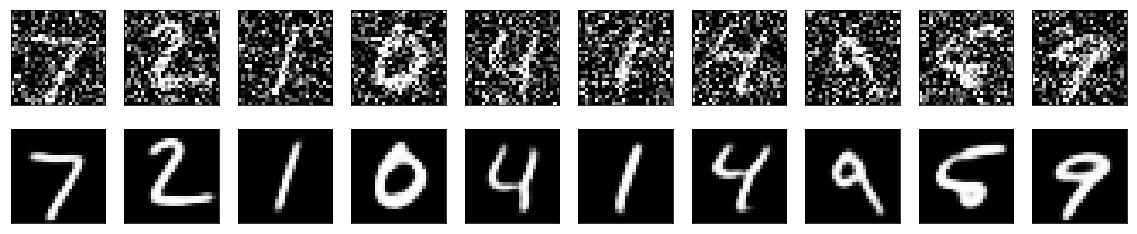

In [187]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()